<a href="https://colab.research.google.com/github/offthetab/NN_homework/blob/main/Variational_autoencoder_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download at first and restart kernel if needed
%%capture
!pip install torchinfo
!pip install torchvision==0.19.0
!pip install pytorch-ignite

In [ ]:
import random
import torch as th
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms.v2 import ToTensor, Compose, Normalize
from torchinfo import summary

from ignite.metrics import SSIM, PSNR, MeanSquaredError
from ignite.engine import Engine

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from scipy.stats import norm


/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [ ]:
torchvision.__version__

'0.19.0+cu121'

In [ ]:
random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [ ]:
train_MNIST = datasets.MNIST('./data', download = True, train = True, transform=ToTensor())
test_MNIST = datasets.MNIST('./data', download = True, train = False, transform=ToTensor())

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:07<00:00, 1324039.70it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 132585.80it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 242778.04it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3193182.83it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Define dataloaders to get batches
batch_size = 128
train_loader = DataLoader(train_MNIST, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_MNIST, batch_size=batch_size, shuffle=False)

In [ ]:
# torch.Size([32, 1, 28, 28] BCHW
train_batch, train_labels = next(iter(train_loader))
train_batch.shape, train_labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
class Encoder(th.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = th.nn.Sequential(
            th.nn.Conv2d(in_channels=1, out_channels=16,  kernel_size=(3,3), stride=(1, 1), padding=(1, 1)),
            th.nn.BatchNorm2d(16),
            th.nn.ReLU(),
            th.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            th.nn.Conv2d(in_channels=16, out_channels=32,  kernel_size=(3,3), stride=(1, 1), padding=(1, 1)),
            th.nn.ReLU(),
            th.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            th.nn.Flatten(),
            th.nn.Linear(in_features=32*7*7, out_features=32),
            th.nn.ReLU(),

        )
        self.fc_mean = th.nn.Sequential(
            th.nn.Linear(in_features=32, out_features=2),
        )
        self.fc_logvar = th.nn.Sequential(
            th.nn.Linear(in_features=32, out_features=2),
        )

    def forward(self, x):
        tmp = self.encoder(x)
        mean = self.fc_mean(tmp)
        logvar = self.fc_logvar(tmp)
        return mean, logvar

In [ ]:
class Decoder(th.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = th.nn.Sequential(
            th.nn.Linear(in_features=2, out_features=32),
            th.nn.ReLU(),
            th.nn.Linear(in_features=32, out_features=32*7*7),
            th.nn.ReLU(),
            th.nn.Unflatten(1, (32, 7, 7)),

            th.nn.Upsample(scale_factor=2, mode='bilinear'),
            th.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3,3), padding=(1, 1)),
            th.nn.BatchNorm2d(16),
            th.nn.ReLU(),

            th.nn.Upsample(scale_factor=2, mode='bilinear'),
            th.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(3,3), padding=(1, 1)),
            th.nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

In [ ]:
class WeightInit():
    def ConvInit(self, layer):
        if isinstance(layer, (th.nn.Conv2d, th.nn.ConvTranspose2d, th.nn.Linear)):
            th.nn.init.xavier_uniform_(layer.weight)
            th.nn.init.zeros_(layer.bias)

In [ ]:
class CVAE(th.nn.Module):
    def __init__(self, Encoder, Decoder):
        super(CVAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

        weightinit = WeightInit()

        Encoder.apply(weightinit.ConvInit)
        Decoder.apply(weightinit.ConvInit)

    def reparameterization(self, mean, logvar): # reparameterization trick
        std = th.exp(0.5*logvar)
        eps = th.randn_like(std)
        return mean + eps*std

    def forward(self, x):
        mean, logvar = self.Encoder(x)
        z = self.reparameterization(mean, logvar) # log var to var
        return self.Decoder(z), mean, logvar

In [ ]:
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')

encoder = Encoder().to(device)
decoder = Decoder().to(device)

net = CVAE(Encoder=encoder, Decoder=decoder).to(device)

In [ ]:
summary(net, input_size=(batch_size, 1, 28, 28), row_settings=["var_names"])

Layer (type (var_name))                  Output Shape              Param #
CVAE (CVAE)                              [128, 1, 28, 28]          --
├─Encoder (Encoder)                      [128, 2]                  --
│    └─Sequential (encoder)              [128, 32]                 --
│    │    └─Conv2d (0)                   [128, 16, 28, 28]         160
│    │    └─BatchNorm2d (1)              [128, 16, 28, 28]         32
│    │    └─ReLU (2)                     [128, 16, 28, 28]         --
│    │    └─MaxPool2d (3)                [128, 16, 14, 14]         --
│    │    └─Conv2d (4)                   [128, 32, 14, 14]         4,640
│    │    └─ReLU (5)                     [128, 32, 14, 14]         --
│    │    └─MaxPool2d (6)                [128, 32, 7, 7]           --
│    │    └─Flatten (7)                  [128, 1568]               --
│    │    └─Linear (8)                   [128, 32]                 50,208
│    │    └─ReLU (9)                     [128, 32]                 --
│    └─

In [ ]:
#  beta regulates balance between MSE and KL. As the value 𝛽 increases, the influence of the KL divergence term
#  in the loss function becomes stronger so latent space tends to be more normal distributed,
#  but this results in a trade-off where the quality of reconstruction (measured by MSE) might decrease.
# beta = 1 lr=0.001 pretty good results
# beta = 1 baaaad

def loss_function(reconstructed_image, image, mean, logvar, beta=0.2):
    MSE = th.nn.functional.mse_loss(reconstructed_image.flatten(), image.flatten(), reduction='sum')
    KL = (-0.5 * th.sum(1 + logvar - mean.pow(2) - logvar.exp()))
    return MSE + beta * KL

opt = th.optim.Adam(net.parameters(), lr=0.001, betas=(0.6, 0.999), weight_decay=0.005)

In [ ]:
train_loss_values = []

num_epochs = 100

for epoch in tqdm(range(1, num_epochs+1)):
    train_loss = 0  # cumulative loss value
    for idx, (images, _) in enumerate(train_loader):
        images = images.to(device) # send batch to CPU or GRU

        net.train()
        reconstructed_image, mean, logvar = net.forward(images) # model predict
        loss_value = loss_function(reconstructed_image, images, mean, logvar)
        train_loss += loss_value.item()

        opt.zero_grad()
        loss_value.backward()
        opt.step()

    train_loss /= len(train_loader)
    train_loss_values.append(train_loss)
    print(f'Epoch: {epoch}; Train MSE + KL loss: {train_loss}')


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1; Train MSE + KL loss: 5572.65333853195
Epoch: 2; Train MSE + KL loss: 4698.9180176822365
Epoch: 3; Train MSE + KL loss: 4505.101231426573
Epoch: 4; Train MSE + KL loss: 4398.380946307802
Epoch: 5; Train MSE + KL loss: 4327.727668160314
Epoch: 6; Train MSE + KL loss: 4272.715886423074
Epoch: 7; Train MSE + KL loss: 4233.127651710754
Epoch: 8; Train MSE + KL loss: 4203.569571228678
Epoch: 9; Train MSE + KL loss: 4168.480712890625
Epoch: 10; Train MSE + KL loss: 4148.65851702009
Epoch: 11; Train MSE + KL loss: 4125.611884078491
Epoch: 12; Train MSE + KL loss: 4104.637039932869
Epoch: 13; Train MSE + KL loss: 4087.8116442064234
Epoch: 14; Train MSE + KL loss: 4072.6714523087685
Epoch: 15; Train MSE + KL loss: 4059.445544667844
Epoch: 16; Train MSE + KL loss: 4046.545861478045
Epoch: 17; Train MSE + KL loss: 4033.28814163696
Epoch: 18; Train MSE + KL loss: 4025.5753556436566
Epoch: 19; Train MSE + KL loss: 4013.880943705024
Epoch: 20; Train MSE + KL loss: 4001.5940227711885
Epoch: 

In [ ]:
# Define the evaluation step
def eval_step(engine, batch):
    net.eval()
    with th.no_grad():
        image, _ = batch
        # noised_images = noise(data)
        # noised_images = noised_images.to(device)
        image = image.to(device)

        reconstructed_image, _, _ = net(image)
        return reconstructed_image, image

# Create the evaluation engine
engine = Engine(eval_step)

# Create the SSIM metric
ssim_metric = SSIM(data_range=1.0)
ssim_metric.attach(engine, 'ssim')

# Run the evaluation
state = engine.run(test_loader)

# Print the average SSIM
SSIM_value = round(state.metrics["ssim"], 3)
print(f'Average SSIM: {SSIM_value}')

# Create the PSNR metric
psnr_metric = PSNR(data_range=1.0)
psnr_metric.attach(engine, 'psnr')

# Run the evaluation
state = engine.run(test_loader)

# Print the average PSNR
PSNR_value = round(state.metrics["psnr"], 3)
print(f'Average PSNR: {PSNR_value}')

Average SSIM: 0.668
Average PSNR: 15.016


<Figure size 1600x1200 with 0 Axes>

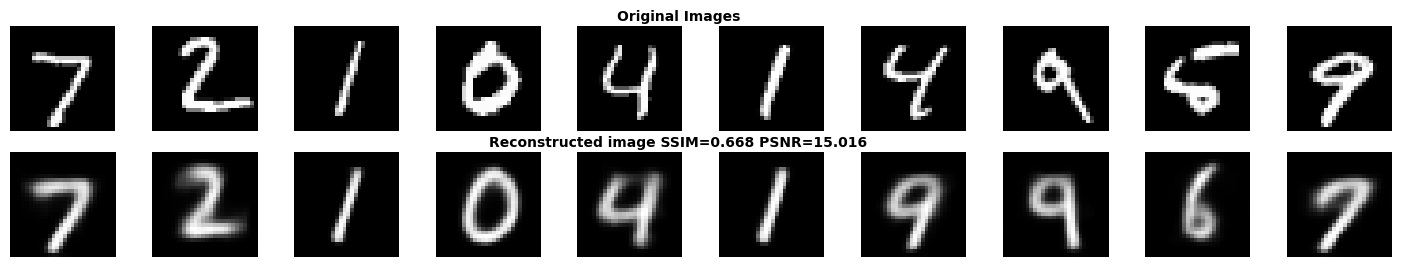

In [ ]:
net.eval()
with th.no_grad():
    for image, _ in test_loader:
        image = image.to(device)
        reconstructed_image, _, _ = net(image)
        break

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 10, figsize=(18, 3))
for i in range(10):
    ax[0, i].imshow(image[i].cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    ax[1, i].imshow(reconstructed_image[i].cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')

fig.text(0.5, 0.91, 'Original Images', ha='center', va='center', fontsize=10, fontweight='bold')
fig.text(0.5, 0.49, f'Reconstructed image SSIM={SSIM_value} PSNR={PSNR_value}', ha='center', va='center', fontsize=10, fontweight='bold')

plt.show()

<Figure size 1600x1200 with 0 Axes>

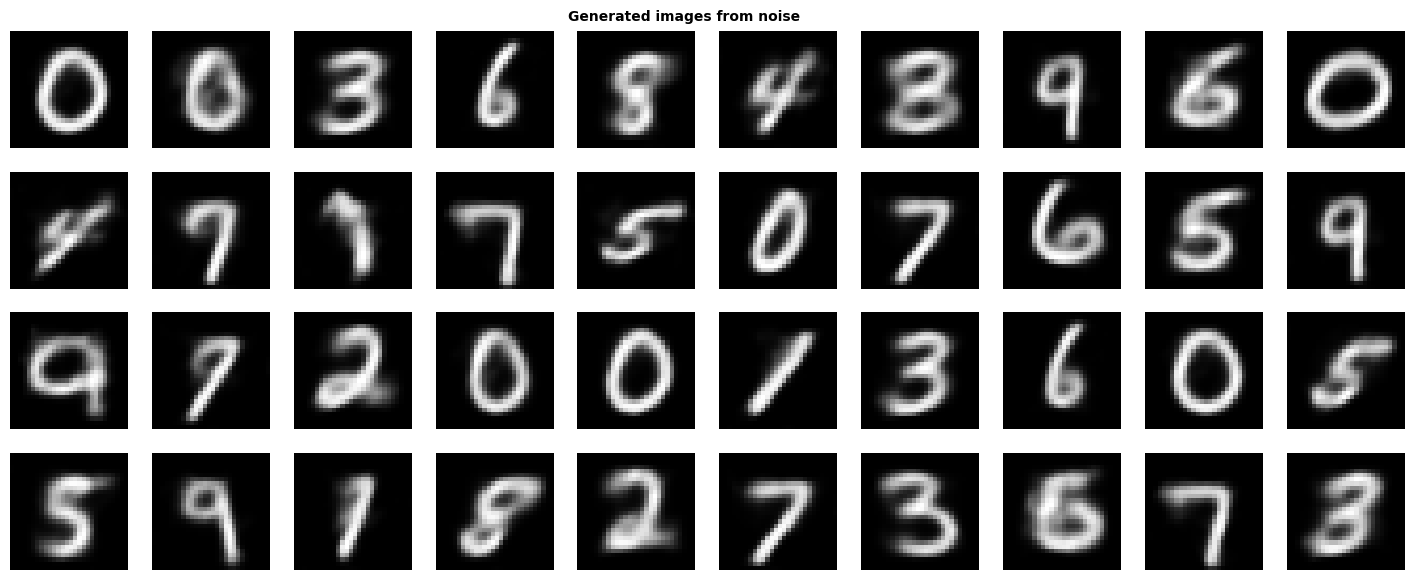

In [ ]:
# generating numbers from random tensor
net.eval()
with th.no_grad():
    noise = th.randn(batch_size, 2).to(device) # 30 is dim of latent space
    noise = noise.to(device)
    image_from_noise = decoder(noise)

plt.figure(dpi=250)
fig, ax = plt.subplots(4, 10, figsize=(18, 7))
for i in range(10):
    ax[0, i].imshow(image_from_noise[i].cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    ax[1, i].imshow(image_from_noise[i+10].cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    ax[2, i].imshow(image_from_noise[i+20].cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    ax[3, i].imshow(image_from_noise[i+30].cpu().numpy().transpose((1, 2, 0)), cmap='gray')


    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
    ax[3, i].axis('OFF')



fig.text(0.5, 0.90, 'Generated images from noise', ha='center', va='center', fontsize=10, fontweight='bold')

plt.show()

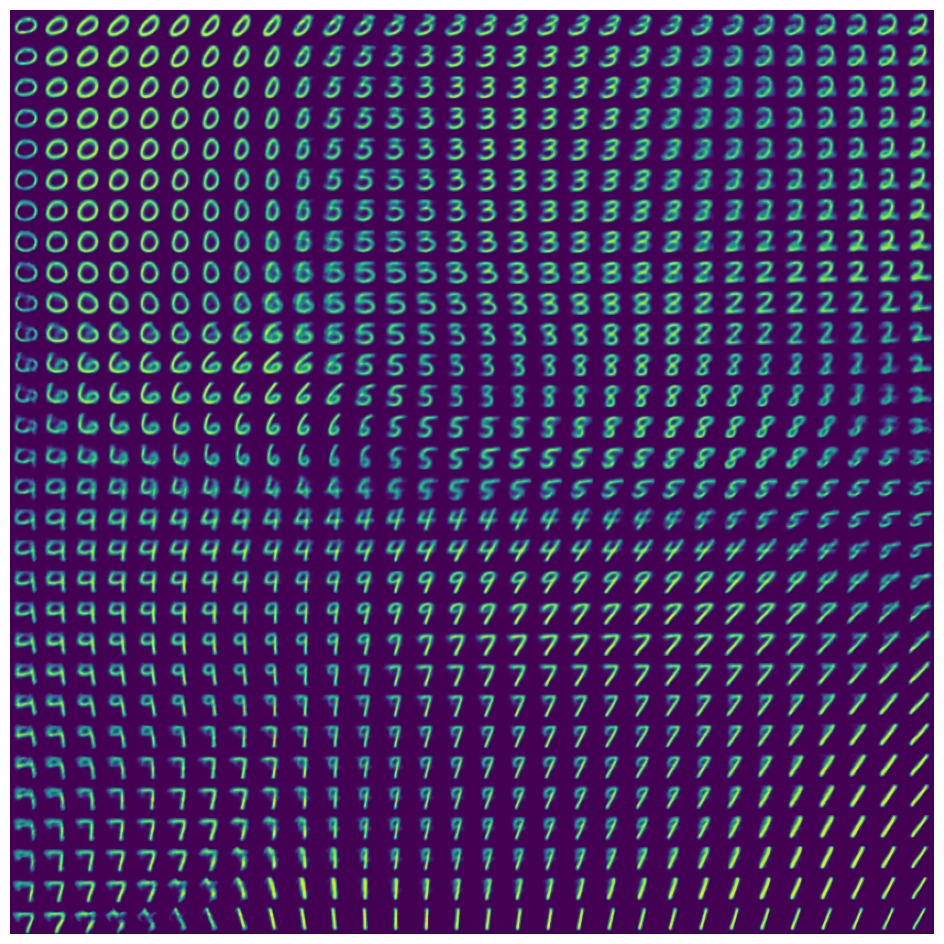

In [ ]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_unif = np.linspace(0.01, 0.99, n)

grid_x = norm.ppf(grid_unif, 0, 1)
grid_y = norm.ppf(grid_unif, 0, 1)

with th.no_grad():
  for i, yi in enumerate(grid_x):
      for j, xi in enumerate(grid_y):
          z_sample = th.Tensor(np.array([[xi, yi]])).to(device)
          x_decoded = decoder(z_sample)
          digit = x_decoded[0].cpu().numpy().reshape(digit_size, digit_size)
          figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.axis('off')
plt.show()

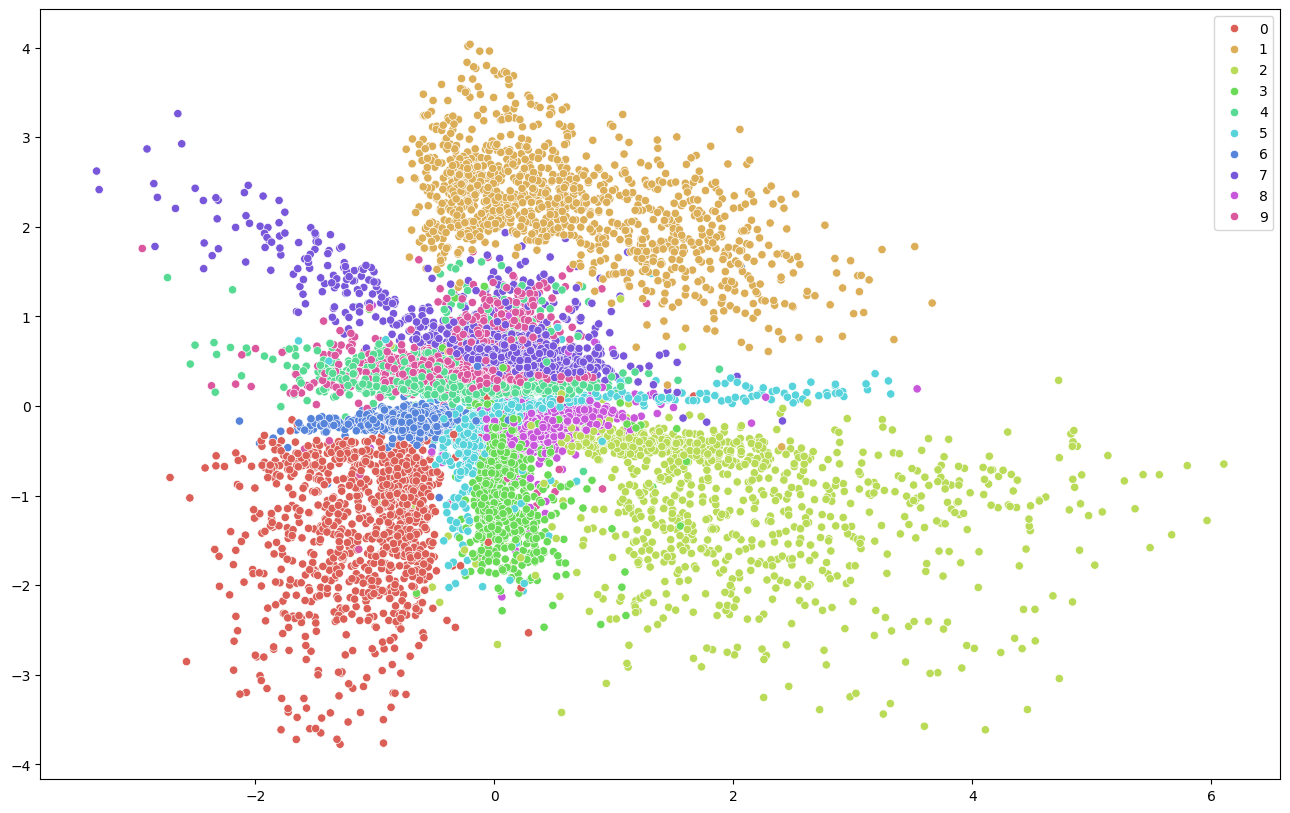

In [ ]:
means = []
labels = []

net.eval()
with th.no_grad():
    for image, label in test_loader:
        image = image.to(device)
        mean, logvar = encoder(image)

        means.append(mean.cpu().numpy())
        labels.append(label.cpu().numpy())


latent_vectors = np.concatenate(means, axis=0)
labels = np.concatenate(labels, axis=0)

plt.figure(figsize=(16,10))
sns.scatterplot(x=latent_vectors[:, 0],
                y=latent_vectors[:, 1],
                hue=labels,
                palette=sns.color_palette("hls", 10))
plt.show()